####   
# Case-study: use of PIC-SURE API to extract data from the JHS cohort
#   
## INTRO - Install the required libraries

##### We install the newly created package picsuRe to facilitate the use of the PIC-SURE API
We also set up the JupyterNB environment

In [9]:
install.demo <- function() {
#install.packages("devtools", repos = "http://cran.r-project.org")
#install.packages("readr", repos = "http://cran.r-project.org")
library(devtools)
library(readr)
    
httr::set_config(httr::config(ssl_verifypeer = 0L, ssl_verifyhost = 0L, ssl_verifystatus  = 0L))
if (!file.exists(Sys.getenv("TAR")))  Sys.setenv(TAR = "/bin/tar")

install_github("hms-dbmi/picsuRe", force = TRUE)
install_github("kaz-yos/tableone", force = TRUE)
library(tableone)
library(picsuRe)
}

suppressMessages(install.demo())

## 1. Data extraction
`environment`: The URL of the environment

`key`: To authenticate with PIC-SURE put your key or token in an otherwise empty text file in your JupyterNotebook's top level folder. The key will be read from there so the key does not get seen by anyone except you.

`variables`: A vector with the variables of interest. You can put a variable, or a path, as you want. You can also use the * key if you want to use a wild card. If an argument corresponds to a node, it will return all the variables below the node

In [22]:
environment <- "https://topmed-dev.hms.harvard.edu"

key <- as.character(read.table("key.csv", sep=",")[1,1])

In [11]:
variables <- c(Consent_groups = "The Jackson Heart Study - phs000286/00. population/consent_groups",
               Age = "Age (yrs) at baseline clinic visit",
               Gender = "01. Demographics/Gender",
               LV_thickness = "M-mode diastolic IV septum thickness in mm",
               Smoking = "*Smoked at least 400 cigarettes",
               History_of_MI = "04a. Has doctor said you had Heart attack",
               Diastolic_BP = "*Diastolic (first BP)")

With the function `picsure`, we build our query, and get the results back from the API. The output is a dataset with the variables of interests. By default, it will return all the patients that have at least one value for a variable.

In [12]:
demo <- picsure(environment, key, variables, verbose = FALSE)

Hi Gregoire_Versmee thank you for using picsuRe!

Waiting for PIC-SURE to return the query
  ...still waiting
  ...still waiting
  ...still waiting

The data.frame downloaded contains 3602 observations of 8 variables. Its size is 144.3 Kb


For simplicity, we exclude the observations where "Gender" is missing

In [13]:
demo <- demo[!(demo$Gender == ""),]

If necessary, you can get a list of all the pathways and variables available by running the `raj()` function. This function takes as argument the environment, the token, and optionally a node where you want to start your list.
It will return a vector with all the pathways available

In [ ]:
#example 1: retrieve the list of all pathways available in the topmed-dev environment
list.variables <- raj(env, key, verbose = FALSE)
#example2: retrieve the list of all pathways available in the environment after the node "The Jackson Heart Study - phs000286"
list.variables2 <- raj(env, key, "The Jackson Heart Study - phs000286")

## 2. Use the data to make statistics
### 2.a. Summary statistics
Let's take a look at the characteristics of our population

In [14]:
catVars <- c("Consent_groups", "Gender", "History_of_MI", "Smoking")
vars <- c("Consent_groups", "Age", "LV_thickness", "Diastolic_BP", "Smoking", "History_of_MI")

paste("We have", nrow(demo), "patients in our population.")
"Table 1: Description of the population from the Jackson Cohort Study"
CreateTableOne(vars, data = demo[,-1], factorVars = catVars, strata = c("Gender"), test = FALSE)

[1] "We have 3536 patients in our population."

[1] "Table 1: Description of the population from the Jackson Cohort Study"

                          Stratified by Gender
                           Female        Male         
  n                         2214          1322        
  Consent_groups (%)                                  
     1                       300 (13.6)    178 (13.5) 
     2                       110 ( 5.0)     65 ( 4.9) 
     3                      1291 (58.3)    806 (61.0) 
     4                       513 (23.2)    273 (20.7) 
  Age (mean (sd))          55.29 (12.74) 54.14 (12.98)
  LV_thickness (mean (sd))  8.61 (1.38)   9.27 (1.52) 
  Diastolic_BP (mean (sd)) 94.21 (11.66) 98.54 (12.26)
  Smoking (%)                                         
                               4 ( 0.2)      2 ( 0.2) 
     No                     1630 (73.6)    734 (55.5) 
     Yes                     580 (26.2)    586 (44.3) 
  History_of_MI (%)                                   
                               4 ( 0.2)      3 ( 0.2) 
     Dont know                 9 ( 0.4)      2 ( 0.2) 
     No           

### 2.b. Comparison of a categorical variable with a continuous one. The sitting diastolic blood pressure between men and women among the JHS cohort

First, let's see the distribution of the diastolic blood pressure among the JHS cohort

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  60.00   88.00   96.00   95.83  104.00  140.00      10 

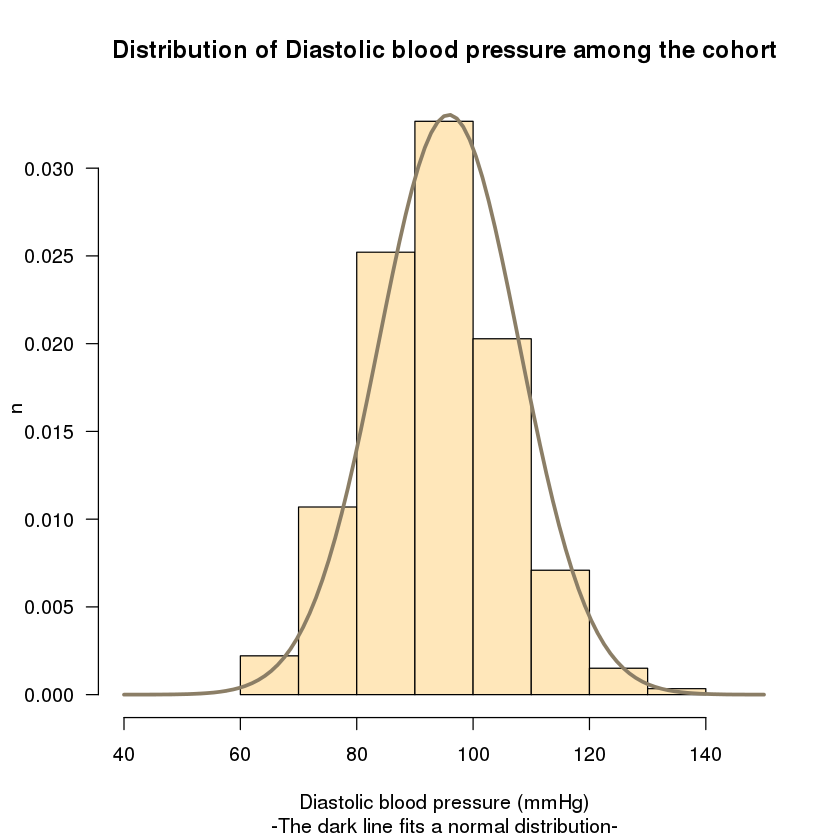

In [15]:
diastolic <- demo$Diastolic_BP
summary(diastolic)
hist(diastolic,
     main="Distribution of Diastolic blood pressure among the cohort",
     sub="-The dark line fits a normal distribution-",
     xlab="Diastolic blood pressure (mmHg)", 
     ylab="n",
     border="black", 
     col="wheat1",
     xlim=c(40,150),
     breaks=10,
     las = 1,
     prob = TRUE
    )
m <- mean(diastolic, na.rm = TRUE)
std <- sqrt(var(diastolic, na.rm = TRUE))
x <- length(diastolic)
curve(dnorm(x, mean=m, sd=std), col="wheat4", lwd=3, add=TRUE, yaxt="n")

We can see that the distribution as a bell-shape curve slightly left skewed. However, our population contains enough patient so that we can apply the central limit theorem for our analysis.
#### Let's run a t-test in order to look for a significant difference of the diastolic BP between men and women¶


	Welch Two Sample t-test

data:  diastolic by gender
t = -10.324, df = 2663.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.148306 -3.504790
sample estimates:
mean in group Female   mean in group Male 
            94.21477             98.54132 


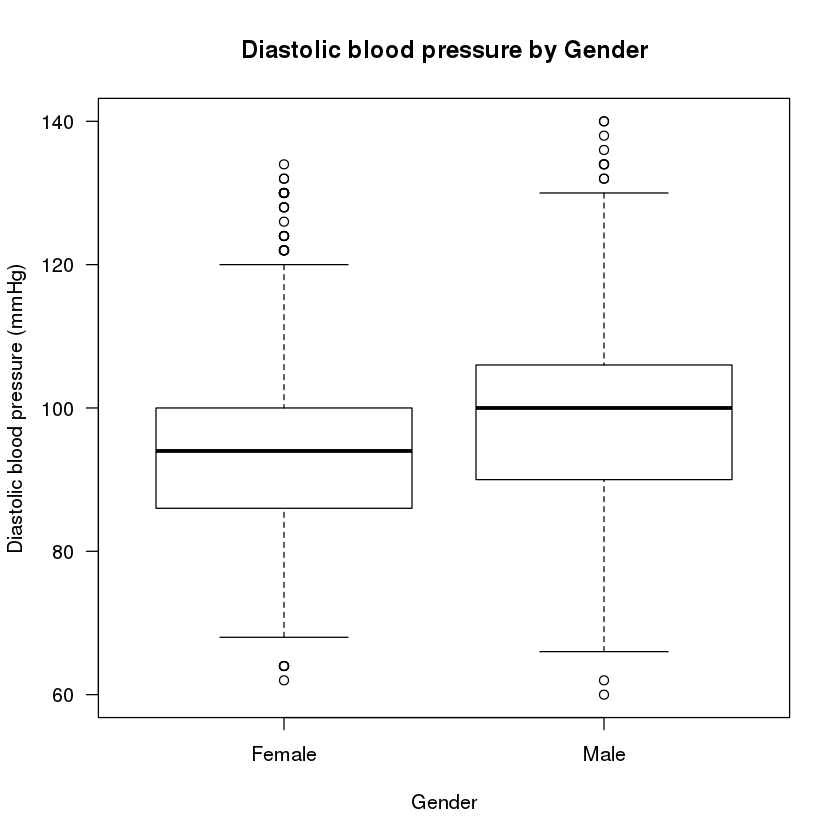

In [16]:
gender <- droplevels(demo$Gender)
t.test(diastolic~gender)
boxplot(diastolic~gender,data=demo, main="Diastolic blood pressure by Gender", xlab="Gender", ylab="Diastolic blood pressure (mmHg)",   las = 1)

The p-value is lower than 0.05, therefore we can conclude that the dastolic blood pressure is statistically significantly lower among the female population of the Jackson cohort than among the male population. This is also visualy significant as looking at the box-plots.

### 2.c. Comparison of 2 categorical variables. History of smoking and past history of Myocardial Infarction.

In [17]:
demo <- demo[((demo$Smoking == "Yes" | demo$Smoking == "No")
            & (demo$History_of_MI == "Yes" | demo$History_of_MI == "No")),]
demo <- droplevels(demo)

Smokers <- demo$Smoking
History_of_MI <- demo$History_of_MI

table(History_of_MI, Smokers)
chisq.test(History_of_MI, Smokers)

             Smokers
History_of_MI   No  Yes
          No  2274 1062
          Yes   83   96


	Pearson's Chi-squared test with Yates' continuity correction

data:  History_of_MI and Smokers
X-squared = 35.556, df = 1, p-value = 2.478e-09


The Chi-Square test concludes that there is a statistically significant higher proportion of history of smoking among people that have a past history of myocardial infarction.

## 3. Subset the population
### 3.a. Data extraction
It can be interesting to be able to retrieve only a subset of our population, especially in the case of very extensive datasets. Here, we are going to compare the thickness of the left ventricular wall among men and women, only from one consent group of the cohort. The picsure API allows us to query only a subset. In the R package, this is translated by adding the `subset` argument

In [24]:
consent_groups <- "The Jackson Heart Study - phs000286/00. population/consent_groups"
gender <- "01. Demographics/Gender"
LV_thickness <- "M-mode diastolic IV septum thickness in mm"
variables <- c(consent_groups, gender, LV_thickness)

subset <- "(The Jackson Heart Study - phs000286/00. population/consent_groups/HMB-IRB)"

demo2 <- picsure(environment, key, variables, subset, verbose = TRUE)

Hi Gregoire_Versmee thank you for using picsuRe!

Retrieving the selected pathways:
  Using the "find" function of PICSURE

Retrieving all variables associated with: /The Jackson Heart Study - phs000286/00. population/consent_groups
/topmed-i2b2/Demo/The Jackson Heart Study - phs000286/The Jackson Heart Study - phs000286/00. population/consent_groups/DS-FDO-IRB/
/topmed-i2b2/Demo/The Jackson Heart Study - phs000286/The Jackson Heart Study - phs000286/00. population/consent_groups/DS-FDO-IRB-NPU/
/topmed-i2b2/Demo/The Jackson Heart Study - phs000286/The Jackson Heart Study - phs000286/00. population/consent_groups/HMB-IRB/
/topmed-i2b2/Demo/The Jackson Heart Study - phs000286/The Jackson Heart Study - phs000286/00. population/consent_groups/HMB-IRB-NPU/

Retrieving all variables associated with: /01. Demographics/Gender
/topmed-i2b2/Demo/The Jackson Heart Study - phs000286/The Jackson Heart Study - phs000286/01. Demographics/Gender/Female/
/topmed-i2b2/Demo/The Jackson Heart Study - phs

### 3.b. Statistical analysis
We can now run a t-test in order to compare the LV wall thickness between men and women

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  5.900   7.800   8.500   8.788   9.500  17.800     753 


	Welch Two Sample t-test

data:  LV_thickness by gender
t = -8.7506, df = 987.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.8831234 -0.5595876
sample estimates:
mean in group Female   mean in group Male 
            8.506943             9.228298 


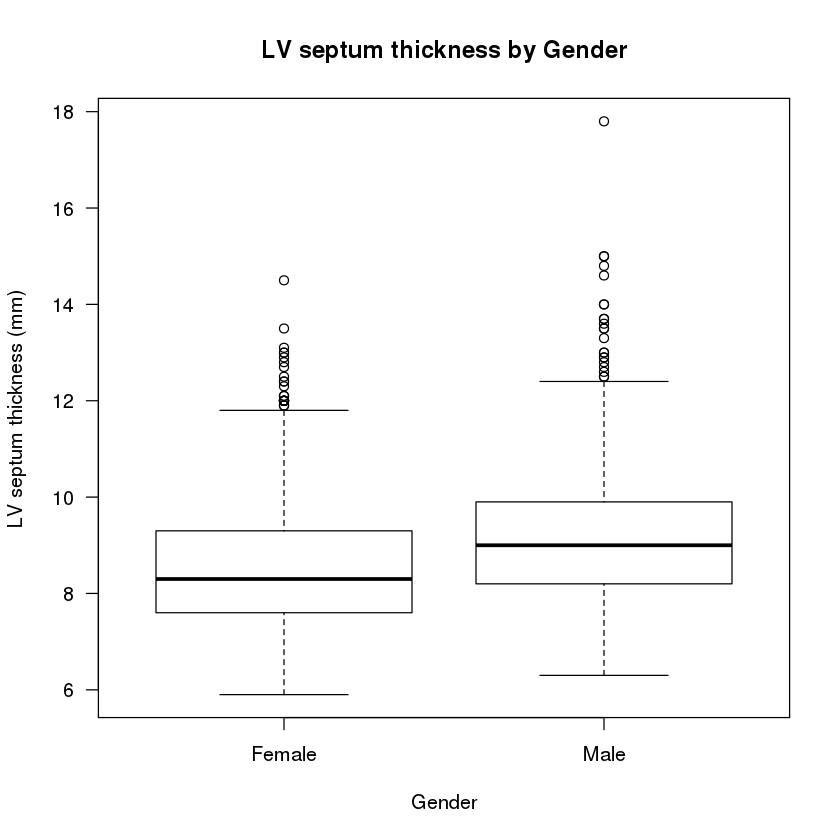

In [19]:
LV_thickness <- demo2$M.mode_diastolic_IV_septum_thickness_in_mm
gender <- demo2$Gender

summary(LV_thickness)
t.test(LV_thickness~gender)
boxplot(LV_thickness~gender, main="LV septum thickness by Gender", xlab="Gender", ylab="LV septum thickness (mm)",   las = 1)